In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import torch
import numpy as np
from lie_vae.datasets import ToyDataset
from lie_vae.blender_axes_wrapper import render_axes
from lie_vae.vae import ChairsVAE
from lie_vae.lie_tools import block_wigner_matrix_multiply, random_quaternions, quaternions_to_eazyz, \
    group_matrix_to_eazyz, group_matrix_to_quaternions, random_group_matrices, rodrigues, quaternions_to_group_matrix
from lie_vae.utils import expand_dim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import OrderedDict

torch.no_grad().__enter__()

In [3]:
device = torch.device('cuda:0')
# Dataset: https://drive.google.com/open?id=1uIbBbqDVlPNP047n4parVMJtOWj21pTJ
dataset = ToyDataset()
spectrum = dataset[0][1].to(device)

def data_gen(g):
    angles = quaternions_to_eazyz(group_matrix_to_quaternions(g))
    return block_wigner_matrix_multiply(angles, expand_dim(spectrum, angles.shape[0]), 3)

In [4]:
def circle(n, mu=None, device=None):
    start = torch.zeros(1, 3, device=device)
    end = torch.randn(1, 3, device=device)
    end = end / end.norm() * 2 * np.pi
    end = end + start
    t = torch.linspace(0, 1, n).to(device)[:, None]
    x = (1-t) * start + end * t
    g = rodrigues(x)
    g[0] = torch.eye(3, device=device)
    if mu is not None:
        if mu == 'random':
            mu = random_group_matrices(1, device=device)[0]
        g = expand_dim(mu, n).bmm(g)
    return g

def random_walk2(n, scale=0.1, start='random', device=None, qr_freq=None):
    x = rodrigues(torch.randn(n-1, 3, device=device) * scale)
    if start == 'random':
        start = random_group_matrices(1, device=device)[0]
    elif start == 'e':
        start = torch.eye(3, device=device)
    else:
        raise ValueError()
    gs = [start]
    for i in range(n-1):
        gs.append(gs[i] @ x[i])
        
        if qr_freq is not None and (i+1)%qr_freq == 0:
            gs[-1] = torch.qr(gs[-1])[0]
    
    return torch.stack(gs, 0)

def random_walk(n, scale=0.1, start='random', device=None, qr_freq=None, integrate=5):
    alg = torch.randn(n, 3, device=device) * scale
    for _ in range(integrate):
        alg = torch.cumsum(alg, 0)
    g = rodrigues(alg)
    g[0] = torch.eye(3, device=device)
    if start is not None:
        if start == 'random':
            start = random_group_matrices(1, device=device)[0]
        g = expand_dim(start, n).bmm(g)
    return g

def repeated_colors(n, sections):
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    repeats = int(np.ceil(n / sections))
    return np.repeat(np.array(colors[:sections]), repeats)

In [24]:
model_names = [
    'toyl3-3-ae-action-q',
    'toyl3-3-ae-action-alg',
    'toyl3-3-ae-action-s2s2',
    'toyl3-3-ae-action-s2s1',
    'toyl3-3-ae-mlp-q',
    'toyl3-3-ae-mlp-alg',
    'toyl3-3-ae-mlp-s2s2',
    'toyl3-3-ae-mlp-s2s1',
    'toyl3-3-ae-action-normal3',
    'toyl3-3-ae-mlp-normal30',
    'toyl3-3-ae-mlp-normal3',
    'toyl3-3-ae-action-vmfq',
    'toyl3-3-ae-mlp-vmf',
    'toyl3-3-vae-action-q',
    'toyl3-3-vae-action-alg',
    'toyl3-3-vae-action-s2s2',
    'toyl3-3-vae-action-s2s1',
    'toyl3-3-vae-mlp-q',
    'toyl3-3-vae-mlp-alg',
    'toyl3-3-vae-mlp-s2s2',
    'toyl3-3-vae-mlp-s2s1',
    'toyl3-3-vae-action-normal3',
    'toyl3-3-vae-mlp-normal30',
    'toyl3-3-vae-mlp-normal3',
    'toyl3-3-vae-action-vmfq',
    'toyl3-3-vae-mlp-vmf',
]
parts = [n.split('-')[2:] for n in model_names]

models = OrderedDict()
for name in model_names:
    parts = name.split('-')[2:]
    
    normal_dims = 3
    if parts[2] == 'normal3':
        latent = 'normal'
    elif parts[2] == 'normal30':
        latent = 'normal'
        normal_dims = 30
    elif parts[2] in ['s2s2', 'alg', 's2s1', 'q']:
        latent = 'so3'
    elif parts[2] in ['vmf', 'vmfq']:
        latent = parts[2]
    else:
        raise RuntimeError()
    
    model = ChairsVAE(
        latent_mode=latent,
        mean_mode=parts[2],
        decoder_mode=parts[1],
        encode_mode='toy',
        deconv_mode='toy',
        rep_copies=3,
        degrees=3,
        deterministic=(parts[0] == 'ae'),
        single_id=True,
        normal_dims=normal_dims
    ).to(device)
    model.load_state_dict(torch.load('outputs/'+name+'/model.pickle'))
    
    models['-'.join(parts)] = model

In [6]:

model = ChairsVAE(
    latent_mode='so3',
    mean_mode='s2s2',
    decoder_mode='action',
    encode_mode='toy',
    deconv_mode='toy',
    rep_copies=3,
    degrees=3,
    deterministic=False,
    single_id=True,
).to(device)
model.load_state_dict(torch.load('outputs/toyl3-3-vae-action-s2s2/model.pickle'))

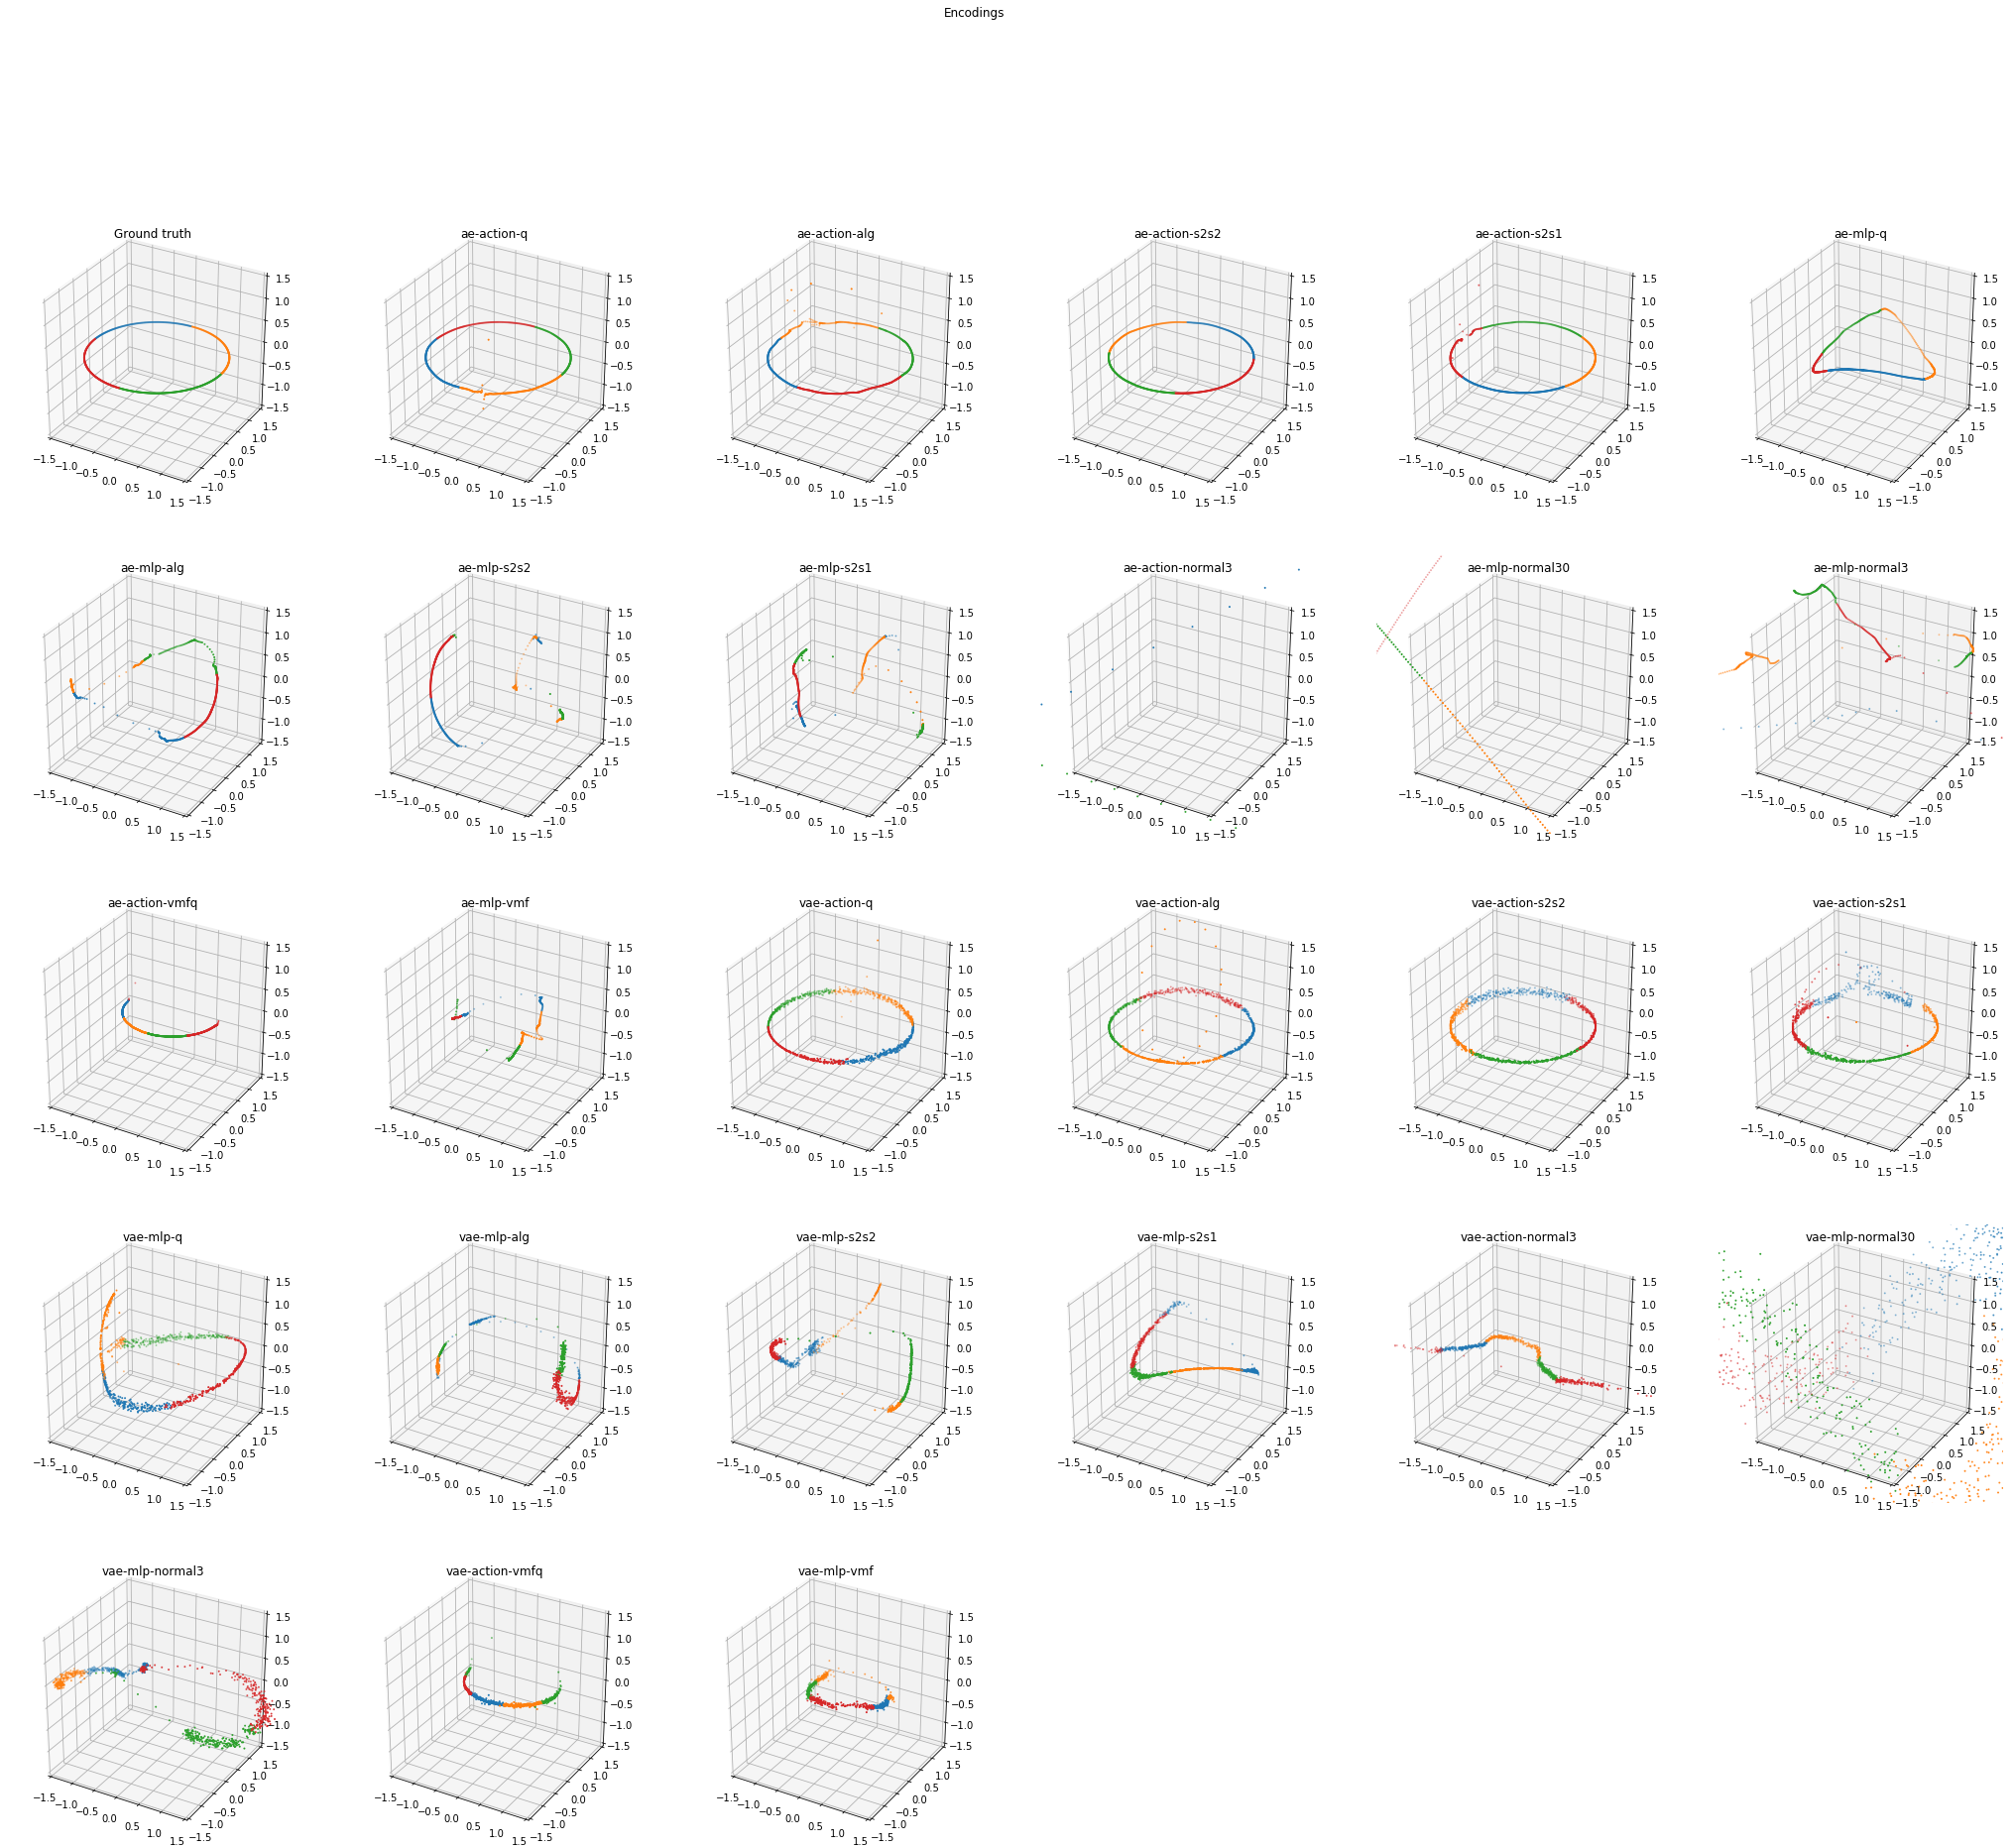

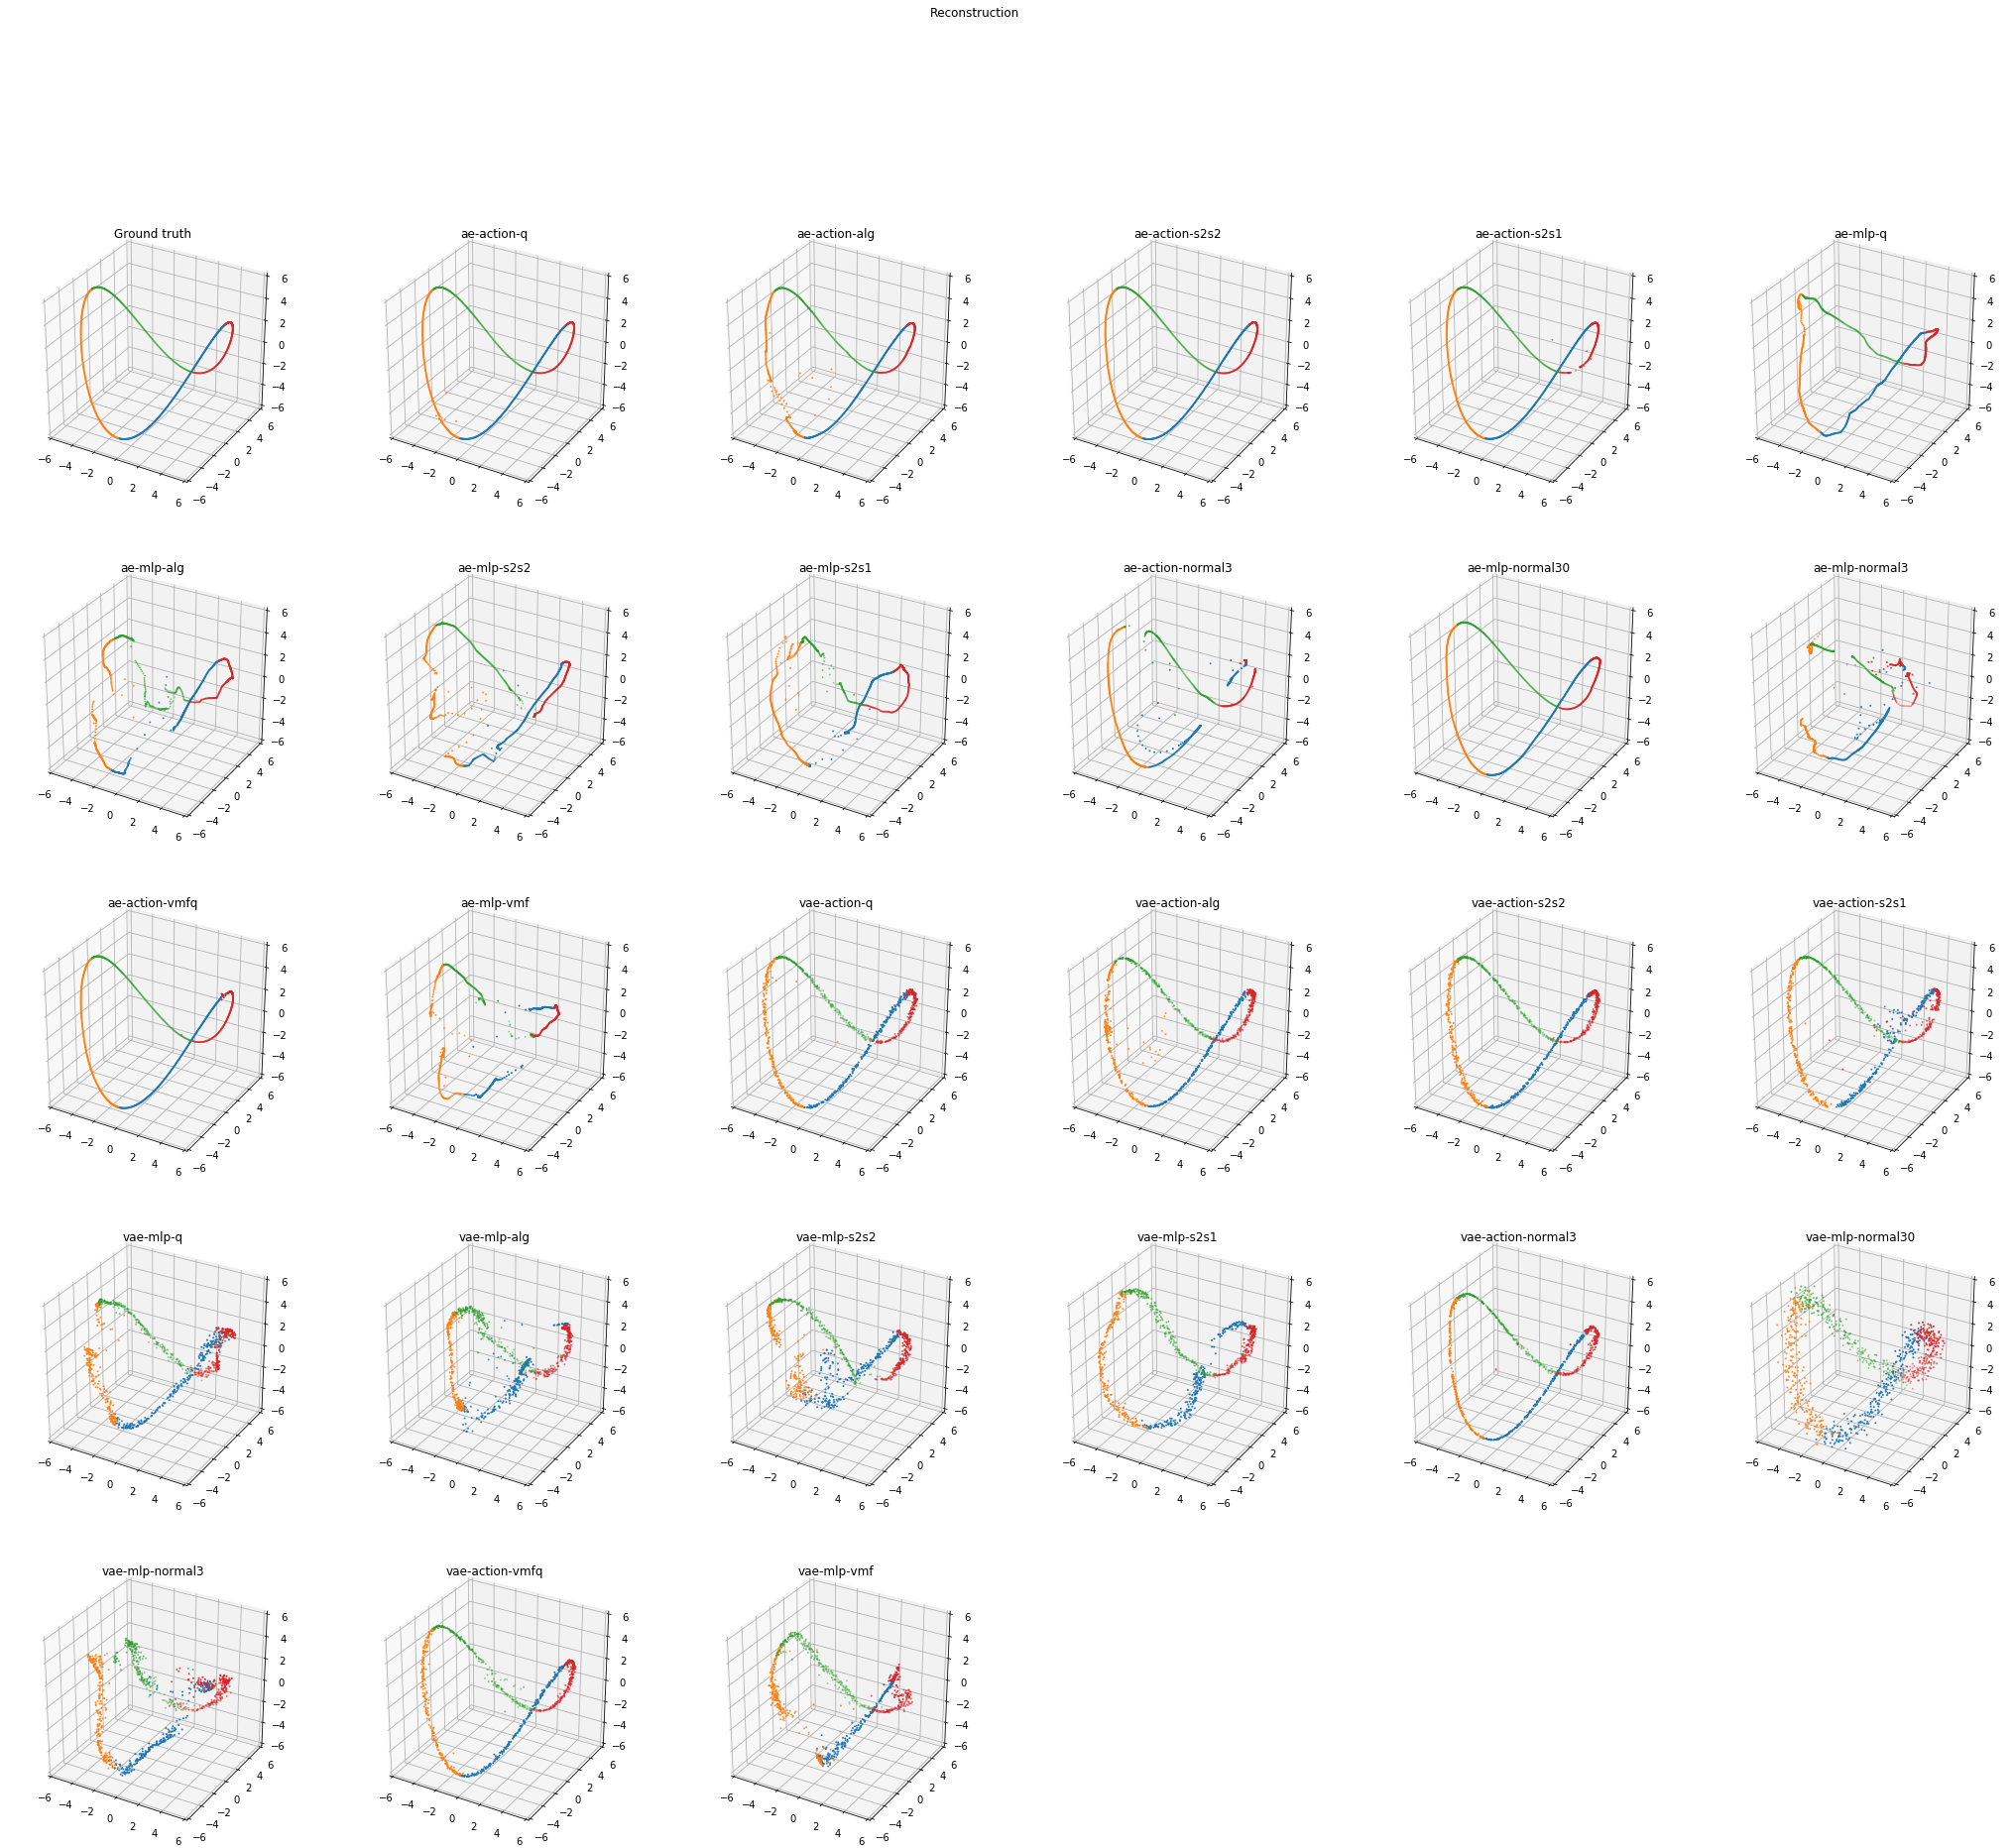

In [26]:
g = circle(1000, 'random', device=device)
# g = random_walk(1000, start='random', scale=1E-12, device=device, qr_freq=1)
data = data_gen(g)

rows = 5
cols = int(np.ceil((len(models)+1) / rows))
fig = plt.figure(figsize=(6*cols, 6*rows))
fig.suptitle('Encodings')
ax = fig.add_subplot(rows, cols, 1, projection='3d')
x = PCA(3).fit_transform(g.view(g.shape[0], -1))
ax.scatter(*x.T, s=1, c=repeated_colors(g.shape[0], 4))
ax.set_title('Ground truth')
ax.set_xlim(-1.5, 1.5), ax.set_ylim(-1.5, 1.5), ax.set_zlim(-1.5, 1.5)

for i, (name, model) in enumerate(models.items()):
    ax = fig.add_subplot(rows, cols, i+2, projection='3d')
    encoding = model.encode(data)[0][0]
    x = PCA(3).fit_transform(encoding.view(g.shape[0], -1))
    ax.scatter(*x.T, s=1, c=repeated_colors(x.shape[0], 4))
    ax.set_title(name)
    ax.set_xlim(-1.5, 1.5), ax.set_ylim(-1.5, 1.5), ax.set_zlim(-1.5, 1.5)
plt.show()

rows = 5
cols = int(np.ceil((len(models)+1) / rows))
fig = plt.figure(figsize=(6*cols, 6*rows))
fig.suptitle('Reconstruction')
ax = fig.add_subplot(rows, cols, 1, projection='3d')
pca = PCA(3)
x = pca.fit_transform(data.view(g.shape[0], -1))
ax.scatter(*x.T, s=1, c=repeated_colors(g.shape[0], 4))
ax.set_title('Ground truth')
ax.set_xlim(-6, 6), ax.set_ylim(-6, 6), ax.set_zlim(-6, 6)

for i, (name, model) in enumerate(models.items()):
    ax = fig.add_subplot(rows, cols, i+2, projection='3d')
    recons = model.forward(data)[0]
#     x = PCA(3).fit_transform(recons.view(g.shape[0], -1))
    x = pca.transform(recons.view(g.shape[0], -1))
    ax.scatter(*x.T, s=1, c=repeated_colors(x.shape[0], 4))
    ax.set_title(name)
    ax.set_xlim(-6, 6), ax.set_ylim(-6, 6), ax.set_zlim(-6, 6)
plt.show()




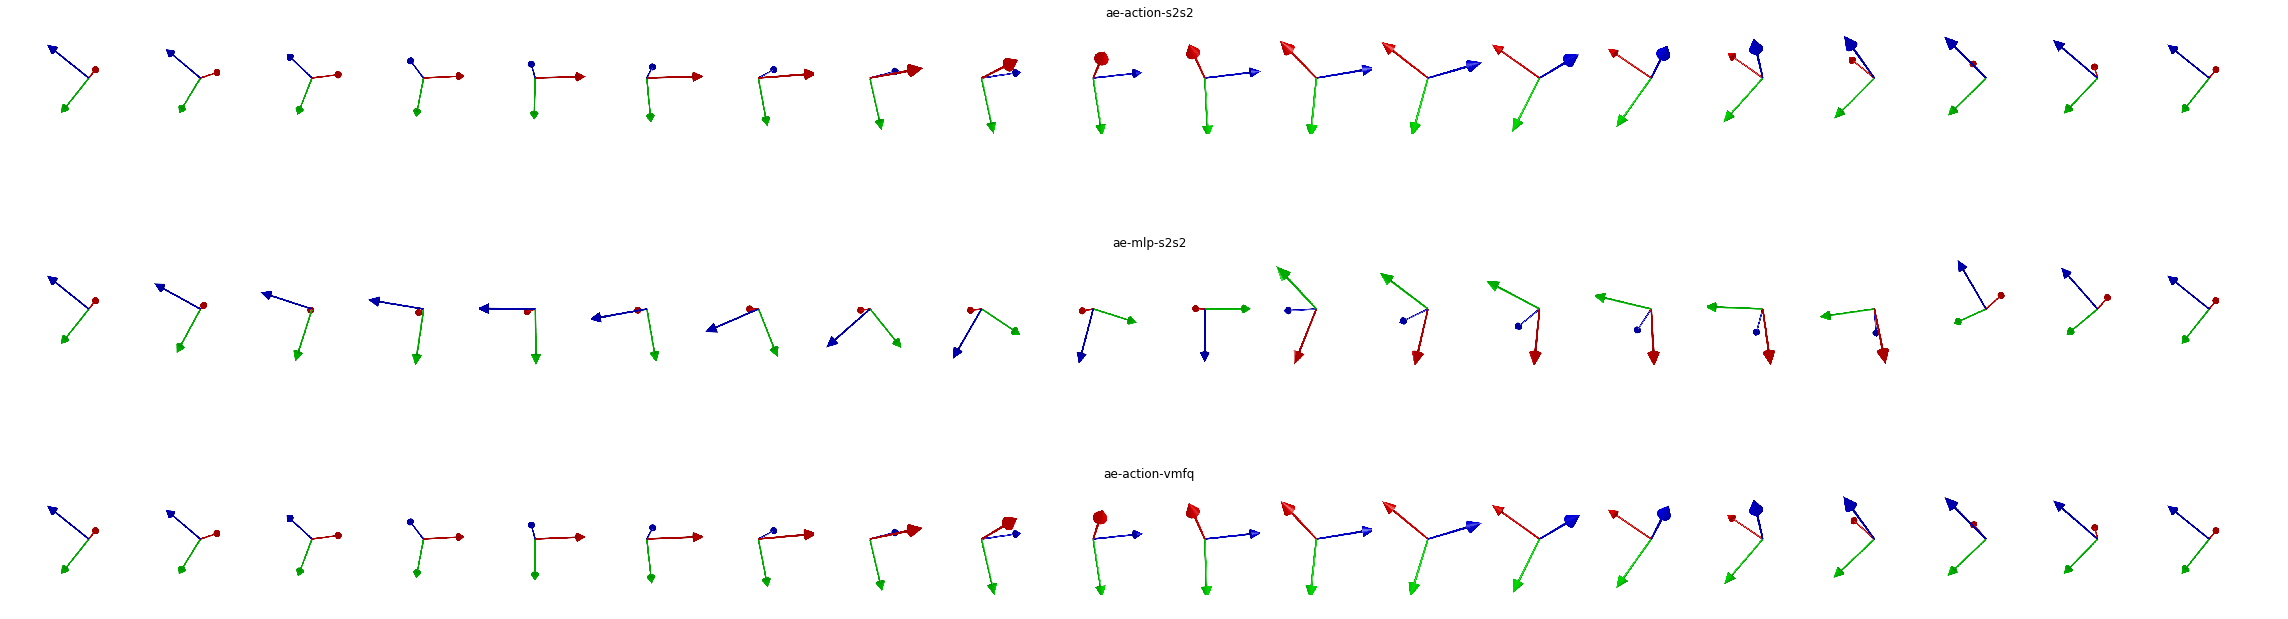

In [47]:
# MAKE SURE TO HAVE BLENDER INSTALLED AND ITS EXECUTABLE IN $PATH

g = circle(20, None, device=device)
# g = random_walk(10, 0.01, device=device)
data = data_gen(g)

names = ['ae-action-s2s2', 'ae-mlp-s2s2', 'ae-action-vmfq']
rows = len(names)
fig = plt.figure(figsize=(40, 4*rows))
base = None
for i, name in enumerate(names):
    model = models[name]
    ax = fig.add_subplot(rows, 1, i+1)
    encodings = model.encode(data)[0][0]
    
    if name == 'ae-action-vmfq':
        encodings = quaternions_to_group_matrix(encodings)
        
    if base is None:
        base = encodings[0]
    else:
        d = base.matmul(encodings[0].inverse())
        encodings = expand_dim(d, g.shape[0]).bmm(encodings)
    
    imgs = render_axes(group_matrix_to_quaternions(encodings), size=200, silent=False)
    ax.imshow(np.concatenate(imgs, 1))
    ax.axis('off')
    ax.set_title(name)
plt.show()

In [43]:
def discontinuities(x, zero_mean=False):
    x = np.asarray(x)
    d = x[1:]-x[:-1]
    disc = (d**2).reshape((x.shape[0]-1, -1)).sum(1)
    if zero_mean:
        disc -= disc.mean()
    return disc

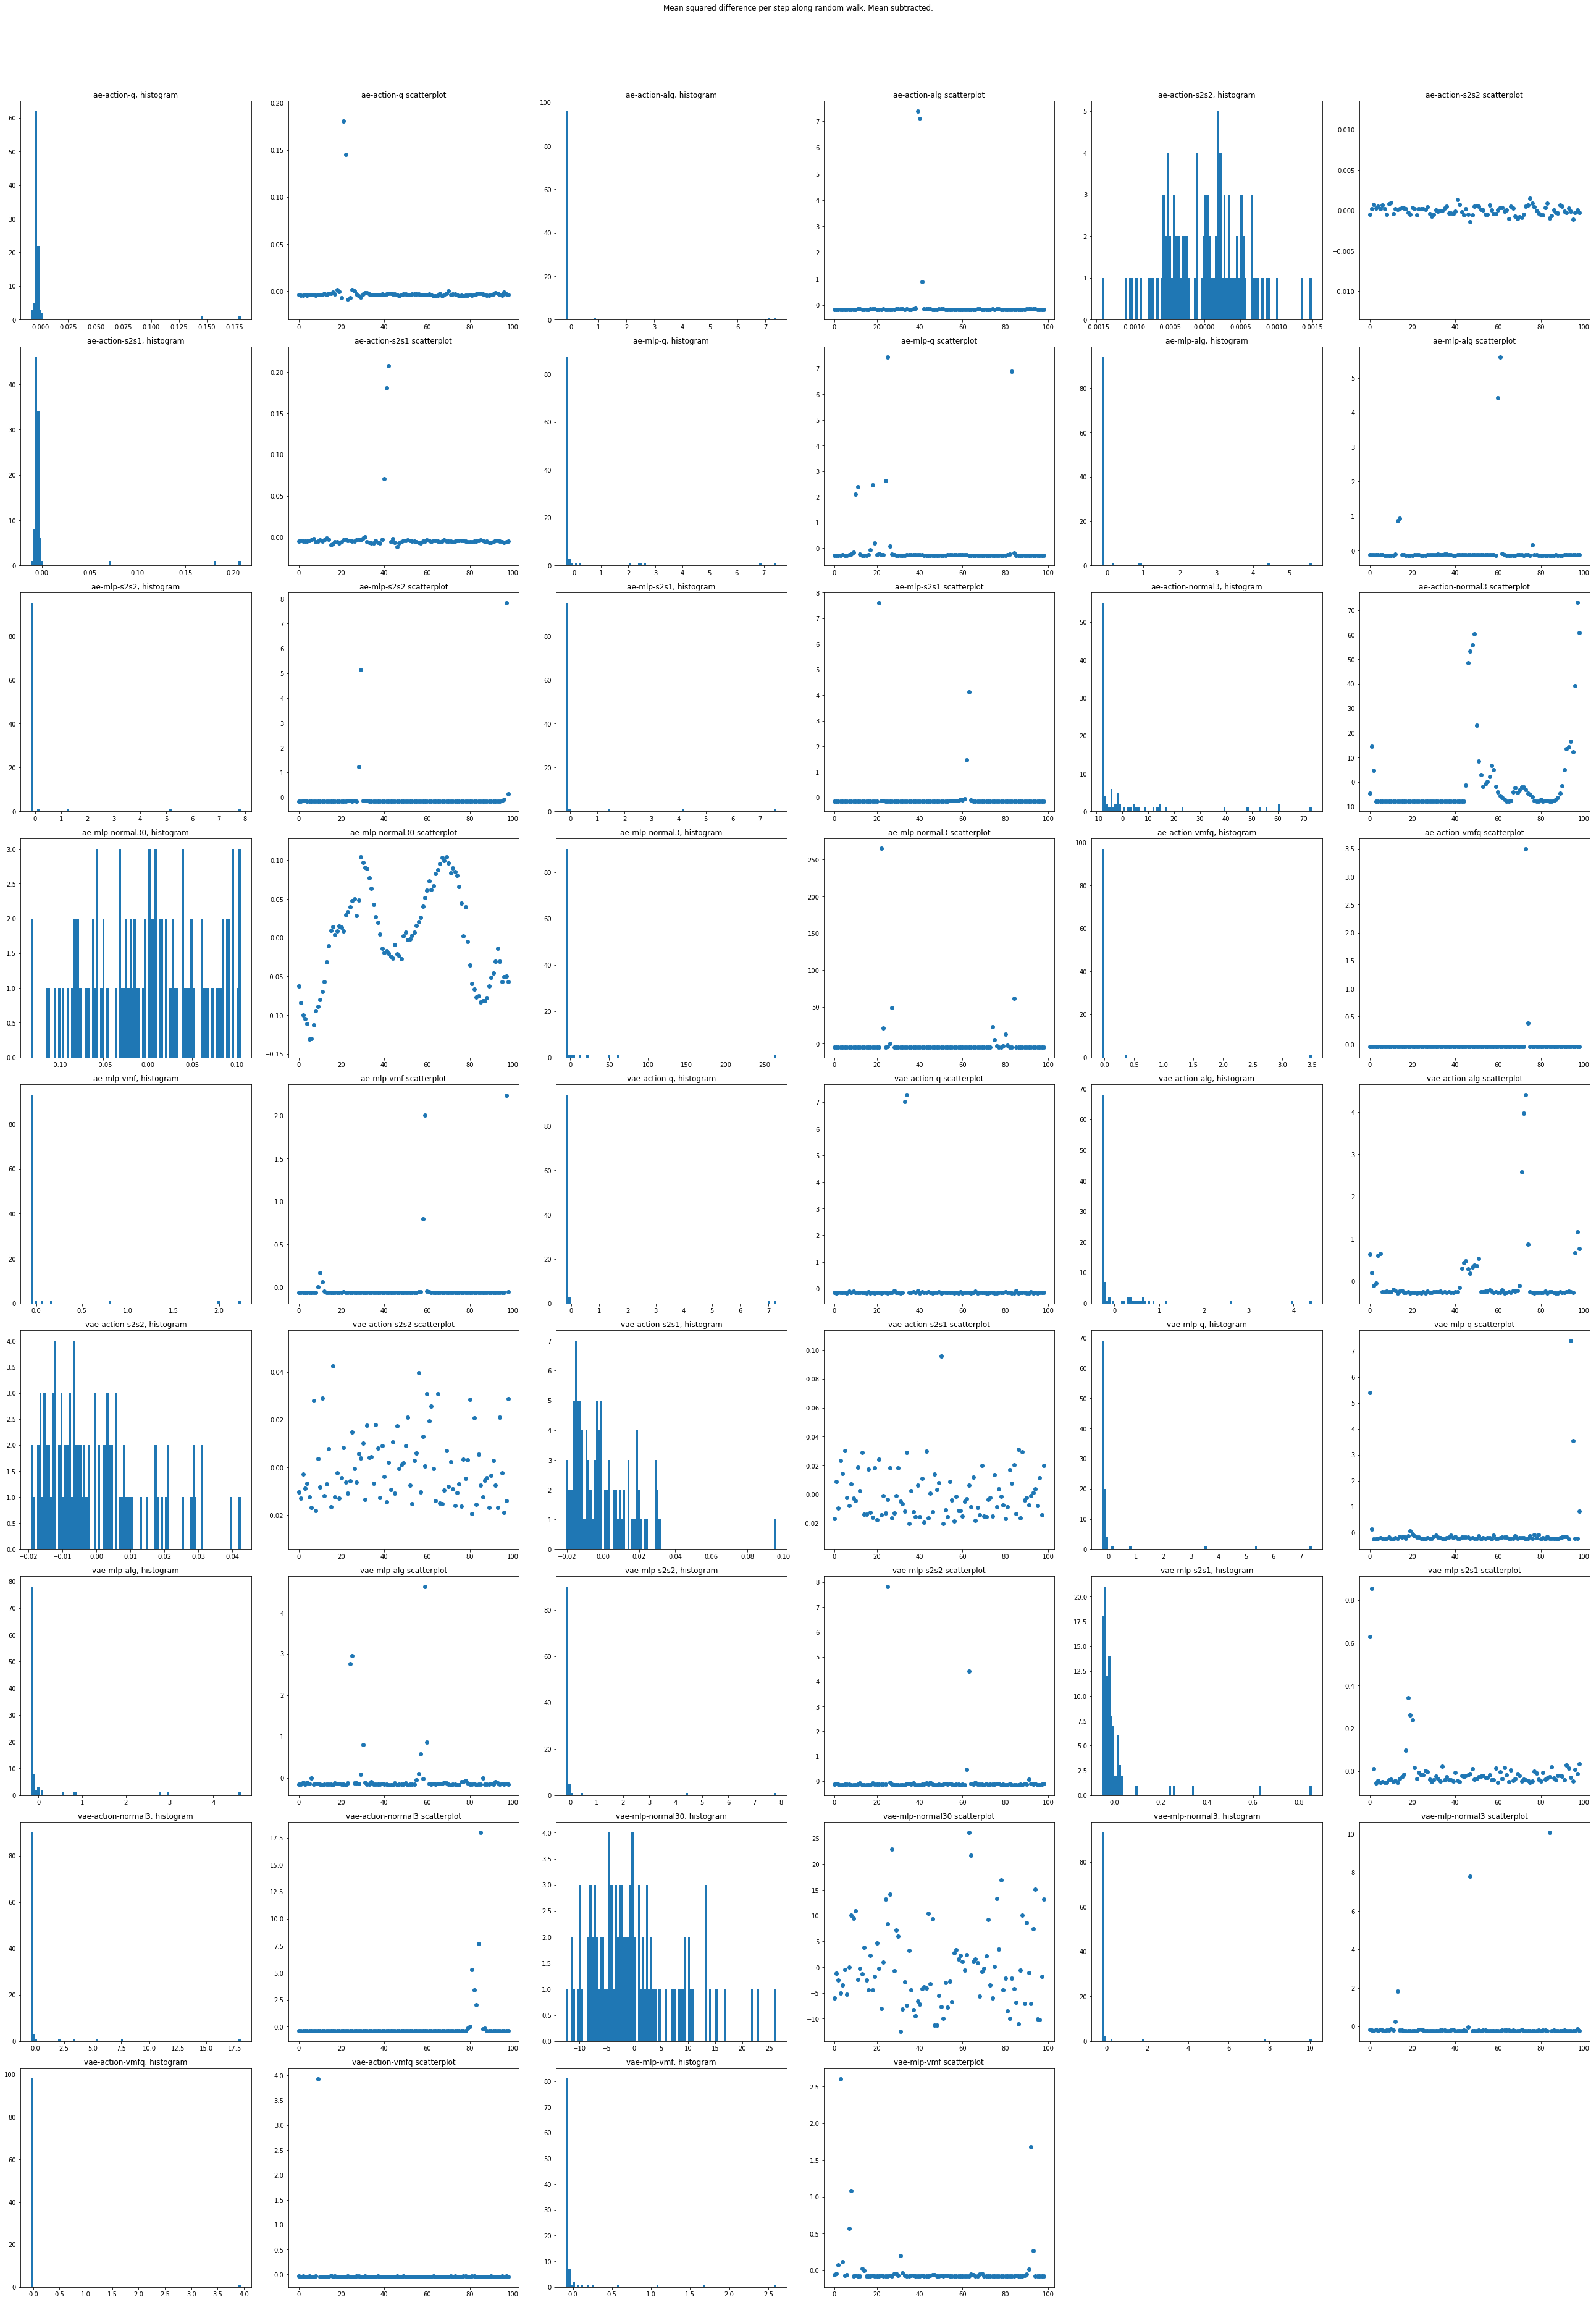

In [44]:
g = circle(100, 'random', device=device)
# g = random_walk(10000, 0.01, device=device, integrate=1)
data = data_gen(g)

rows = 10
cols = int(np.ceil((len(models)+1) / rows)) * 2
fig = plt.figure(figsize=(6*cols, 6*rows))
fig.suptitle('Mean squared difference per step along random walk. Mean subtracted.')
for i, (name, model) in enumerate(models.items()):
    encodings = model.encode(data)[0][0]
    disc = discontinuities(encodings, zero_mean=True)
    
    ax = fig.add_subplot(rows, cols, (2*i)+1)
    ax.hist(disc, bins=100)
    ax.set_title(name + ', histogram')
    
    ax = fig.add_subplot(rows, cols, (2*i)+2)
    ax.scatter(np.arange(disc.shape[0]), disc)
    ax.set_title(name + ' scatterplot')
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])